In [ ]:
%matplotlib inline

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import networkx as nx

%matplotlib inline 

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [14]:
class RRT:
    def __init__(self, x_init):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(tuple(x_init))
                
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_new))
    
    def add_edge(self, x_near, x_new, u):
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u)
        
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()

In [4]:
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
from grid import create_grid
zmax = 10
safe_distance = 1
grid = create_grid(data, drone_altitude=zmax, safety_distance=safe_distance)

In [6]:
from sampling import Sampler

sampler = Sampler(data, zmax=zmax, safe_distance=safe_distance)
free_samples = sampler.samples(1000)

print("free_space_samples: {}".format(len(free_samples)))

free_space_samples: 1000


In [86]:
class PathPlanning:
    def __init__(self, sampler, free_samples):
        self._sampler = sampler
        self._free_samples = free_samples

    def select_input(self, x_rand, x_near):
        x = x_rand[0] - x_near[0]
        y = x_rand[1] - x_near[1]
        return np.arctan2(y, x)

    # def simulate(self, state, angle, v, dt):
    #     x = state[0]
    #     y = state[1]
    #     theta = state[2]
    # 
    #     nx = x + v * np.cos(theta) * dt
    #     ny = y + v * np.sin(theta) * dt
    #     ntheta = theta + v * np.tan(angle) * dt
    #     return [nx, ny, ntheta]

    def steer(self, x1, x2):
        theta = x1[2]
        angle = np.arctan2(x2[1] - x1[1], x2[0] - x1[0]) - theta
        angle = np.arctan2(np.sin(angle), np.cos(theta))
        #angle = np.random.normal(angle, ANGLE_STDDEV)
        #angle = np.clip(angle, -MAX_STEERING_ANGLE, MAX_STEERING_ANGLE)
        return angle

    def nearest_neighbor(self, x_rand, rrt):
        vertices = list(rrt.vertices)
        tree = KDTree(vertices)
        inds = tree.query([x_rand], k=1, return_distance=False)[0]
        return vertices[inds[0]]

    def new_state(self, x_near, u, v, dt):
        return [x_near[0] + v * np.cos(u) * dt,
                x_near[1] + v * np.sin(u) * dt, 
                self._sampler.zmax]
    
    def step_from_to(self, num_extensions, x_near, x_rand, angle, v, dt):
        if self._sampler.norm(x_near, x_rand) < 2.:
            if not self.collision(x_rand):
                return x_rand
            else:
                return None

        states = [x_near]
        for _ in range(num_extensions):
            state = self.new_state(states[-1], angle, v, dt)
            if self.collision(state):
                break
            states.append(state)

        if len(states) > 1:
            return [states[-1][0], states[-1][1], self._sampler.zmax]
        else:
            return None

    def collision(self, s):
        in_collision = False
        idxs = self._sampler.tree.query([[s[0], s[1]]], return_distance=False)[0]
        if len(idxs) > 0:
            p = self._sampler.polygons[idxs[0]]
            if p.contains(s) and p.height >= s[2]:
                in_collision = True
        return in_collision

    def generate_RRT(self, x_init, x_goal, num_vertices, num_extensions, v, dt, epsilon=0.1):
        rrt = RRT(x_init)
        # Nearest node to the goal
        x_goal_near = x_init
        
        if self._sampler.norm(x_init, x_goal) < 1.:
            rrt.add_edge(x_init, x_goal, 0)
            return rrt

        for i in range(num_vertices):
            #print("i:{}".format(i))
            if np.random.uniform() < epsilon:
                idx = np.random.randint(0, len(self._free_samples), 1)[0]
                #print("\tidx:{}".format(idx))
                x_rand = self._free_samples[idx]
            else:
                x_rand = x_goal
                #print("\tto_goal")

            x_near = self.nearest_neighbor(x_rand, rrt)
            #print("\tx_near:{}".format(x_near))
            u = self.select_input(x_rand, x_near)
            #print("\tu:{}".format(u))
            x_new = self.step_from_to(num_extensions, x_near, x_rand, u, v, dt)

            if not x_new is None:
                # the orientation `u` will be added as metadata to
                # the edge
                #rrt.add_edge(x_near, x_new, u)
                rrt.add_edge(x_near, x_new, 
                             self._sampler.norm(x_near, x_new))
            #else:
            #    print("\tNone")

            x_goal_near = self.nearest_neighbor(x_goal, rrt)
            # if there is a node in node close to goal, stop searching
            if self._sampler.norm(x_goal_near, x_goal) < 2.:
                rrt.add_edge(x_goal_near, x_goal, 0)
                return rrt, x_goal, True
        
        return rrt, x_goal_near, False   

In [96]:
pp = PathPlanning(sampler=sampler, free_samples=free_samples)

def tmp():
    while True:
        x = sampler.sample()
        if not pp.collision(x):
            return x


x_init = tmp()
x_goal = tmp()
print("x_init: {}\nx_goal: {}\nnorm: {}".format(x_init,
                                                x_goal, 
                                                sampler.norm(x_init, x_goal)))

dt = 0.1
v = 5.
rrt, x, x_state  = pp.generate_RRT(x_init, x_goal, 200, 10, v, dt, 0.3)

# for i in range(100):
#     #print("run: {}".format(i))
#     path_planning_3.generate_to_goal_RRT(rrt, x_goal, 200, v, dt, 0.3)
#     x_goal_near = path_planning_3.nearest_neighbor(x_goal, rrt)
#     # if there is a node in node close to goal, stop searching
#     if np.linalg.norm(np.asarray(x_goal) - np.asarray(x_goal_near)) < 1.:
#         print("goal_reached")
#         break
        

#for (n1, n2) in g.edges:
#    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
print(len(rrt.vertices))
print(len(rrt.edges))
print("x: {}, x_state: {}".format(x, x_state))

x_init: [174.905653574439, -86.68463967210477, 10]
x_goal: [452.46319503346723, 128.84744452341488, 10]
norm: 351.414666937003


42
41
x: (213.74387588433248, -77.96090677649305, 10), x_state: False


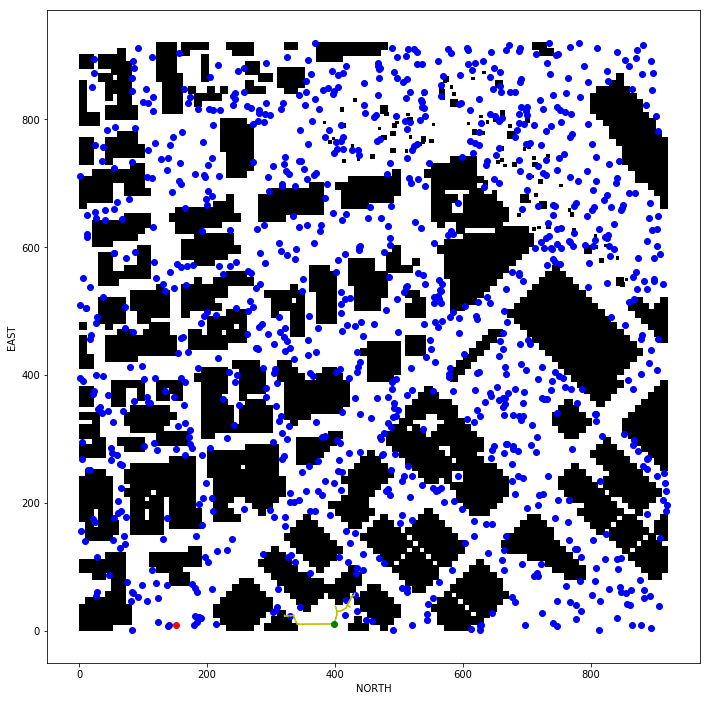

In [91]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# draw all free space samples
for s in free_samples:
    plt.scatter(s[1] - sampler.emin, s[0] - sampler.nmin, c='blue')
    
    
for (n1, n2) in rrt.edges:
    plt.plot([n1[1] - sampler.emin, n2[1] - sampler.emin], 
             [n1[0] - sampler.nmin, n2[0] - sampler.nmin], 'y-')
    
plt.plot(x_init[1] - sampler.emin, x_init[0] - sampler.nmin, 'go')
plt.plot(x_goal[1] - sampler.emin, x_goal[0] - sampler.nmin, 'ro')
    
    

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()
#for n in rrt.vertices:
#    print("n: {} out_degree: {}".format(n, 
#                                        len(list(rrt.tree.succ[n]))))

#print(x_init)
#print(tuple(x_goal) in rrt.vertices)

# A* on DiGraph

In [84]:
#nx.draw(rrt.tree)
#plt.show()

In [92]:
from queue import PriorityQueue

def heuristic(n1, n2):
    return sampler.norm(n2, n1)

def a_star(di_graph, h, start, goal):
    """Modified A* to work with NetworkX DiGraphs."""
    
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in di_graph.succ[current_node]:
                cost = di_graph.edges[current_node, next_node]['orientation']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
                    
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

In [97]:
x_init_tuple = tuple(x_init)
h_path, cost = a_star(rrt.tree, heuristic, x_init_tuple, x)

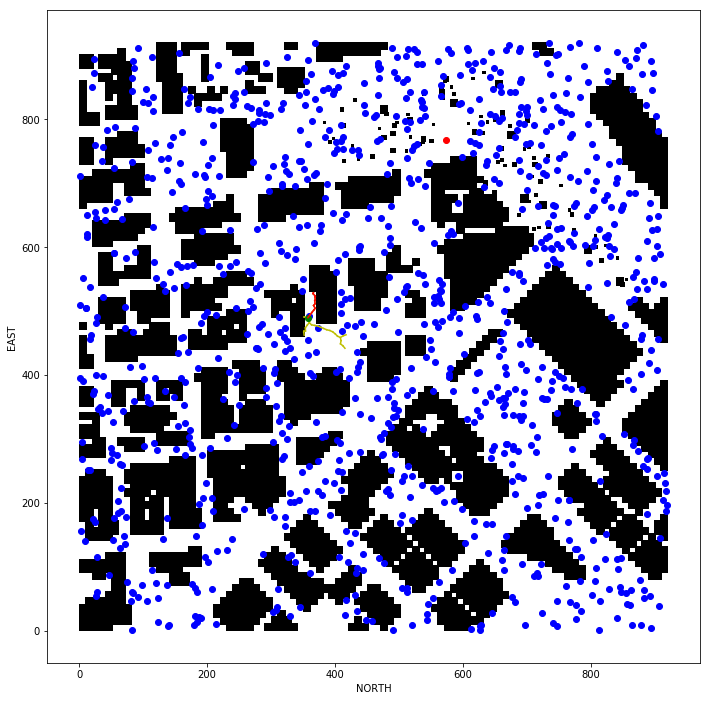

In [98]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# draw all free space samples
for s in free_samples:
    plt.scatter(s[1] - sampler.emin, s[0] - sampler.nmin, c='blue')
    
    
for (n1, n2) in rrt.edges:
    plt.plot([n1[1] - sampler.emin, n2[1] - sampler.emin], 
             [n1[0] - sampler.nmin, n2[0] - sampler.nmin], 'y-')
    
plt.plot(x_init[1] - sampler.emin, x_init[0] - sampler.nmin, 'go')
plt.plot(x_goal[1] - sampler.emin, x_goal[0] - sampler.nmin, 'ro')

for i in range(len(h_path)-1):
    p1 = h_path[i]
    p2 = h_path[i+1]
    plt.plot([p1[1] - sampler.emin, p2[1] - sampler.emin], 
             [p1[0] - sampler.nmin, p2[0] - sampler.nmin], 
             'r-')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()


In [114]:
import re

line = "lat0 37.792480, lon0 -122.397450"
matches = re.match(r'lat0 (.*), lon0 (.*)', line)
if matches:
    print(matches.group(1), matches.group(2))


37.792480 -122.397450
